In [1]:
%load_ext autoreload
%autoreload 2
    
import tensorflow as tf
from tensorflow  import keras
import numpy as np

import librosa 
from dataset import WavDataset
import matplotlib.pyplot as plt
from tqdm import tqdm
from config import *
import h5py
import soundfile as sf
from scipy.signal import resample_poly
from util import DEFAULT_TOKENS
import librosa

2024-10-01 11:34:53.795353: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-01 11:34:53.795401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-01 11:34:53.897125: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 11:34:54.135871: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 11:34:55.656528: W tensorflow/comp

In [2]:
from models import build_resnet16
from keras import metrics
import keras_cv

X_shape = (40, 107, 1)

model = build_resnet16(input_shape=X_shape, n_classes=5)
model.compile(optimizer='adam',
              loss=keras_cv.losses.FocalLoss(alpha=0.25, gamma=2),  # TODO tweak
              metrics=[
                metrics.Recall(thresholds=0.5),
                metrics.Precision(thresholds=0.5),
                metrics.AUC(curve='pr', name='auc_pr')
              ])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 40, 107,   │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 40, 107,   │        160 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 40, 107,   │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 40, 107,   │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 20, 54,    │      2,320 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 54,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 20, 54,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 20, 54,    │      2,320 │ re_lu_1[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 20, 54,    │        272 │ re_lu[0][0]       │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 54,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 54,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 20, 54,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 20, 54,    │          0 │ add[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 20, 54,    │      2,320 │ re_lu_2[0][0]     │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 20, 54,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 20, 54,    │          0 │ batch_normalizat… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 20, 54,    │      2,320 │ re_lu_3[0][0]   

 Total params: 176,661 (690.08 KB)

 Trainable params: 175,509 (685.58 KB)

 Non-trainable params: 1,152 (4.50 KB)

In [3]:
from AL import AL_split

X = np.load(INTERMEDIATE / 'logmel_multiclass_noise.npy')
Y = np.load(INTERMEDIATE / 'logmel_labels_multiclass_noise.npy')

train, pool, test = AL_split(X, Y)
X_train, Y_train = train
X_pool, Y_pool = pool
X_test, Y_test = test
(X_pool.shape, Y_pool.shape), (X_train.shape, Y_train.shape), (X_test.shape, Y_test.shape)

(((135446, 40, 107), (135446, 5)),
 ((33862, 40, 107), (33862, 5)),
 ((42328, 40, 107), (42328, 5)))

In [4]:
from preprocessing import oversample_minority_classes

X_train_full = np.concatenate([X_train, X_pool], axis=0)
Y_train_full = np.concatenate([Y_train, Y_pool], axis=0)

X_train_full, Y_train_full = oversample_minority_classes( # TODO does this work??
    X_train_full, Y_train_full)

import gc; gc.collect()

In [5]:
Y_train_full.sum(axis=0)

array([   896,    896,    896,    896, 166674])

In [6]:
from preprocessing import undersample, oversample_minority_classes

hist = model.fit(
    x=X_train_full, y=Y_train_full, 
    batch_size=32,
    validation_data=(X_test, Y_test),
    epochs=1,
    verbose=2
)

hist.history

2024-10-01 11:35:33.752706: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 2914816960 exceeds 10% of free system memory.


5321/5321 - 319s - 60ms/step - auc_pr: 0.9974 - loss: 0.0120 - precision: 0.9892 - recall: 0.9750 - val_auc_pr: 0.9983 - val_loss: 0.0103 - val_precision: 0.9939 - val_recall: 0.9601


{'auc_pr': [0.9973992109298706],
 'loss': [0.012039446271955967],
 'precision': [0.9892136454582214],
 'recall': [0.974961519241333],
 'val_auc_pr': [0.9983251690864563],
 'val_loss': [0.010311766527593136],
 'val_precision': [0.9939104914665222],
 'val_recall': [0.960144579410553]}

1323/1323 - 18s - 14ms/step


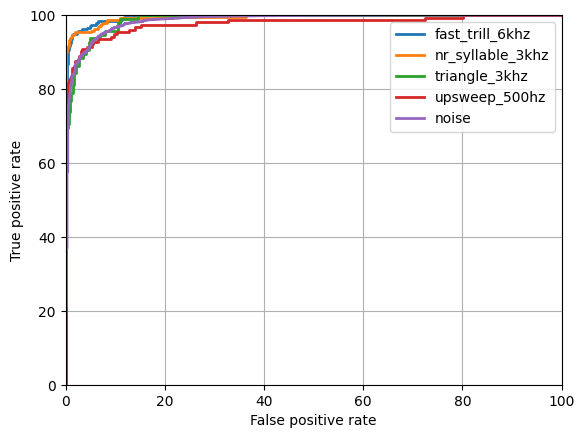

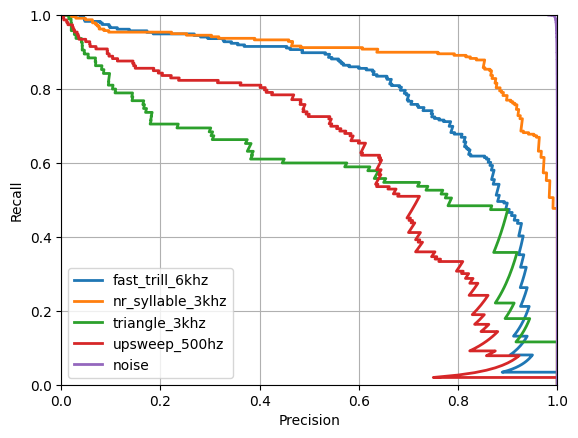

In [7]:
from sklearn.metrics import roc_curve, precision_recall_curve

def plot_pr(name, labels, predictions, **kwargs):
    prec, rec, _ = precision_recall_curve(labels, predictions)
    plt.plot(prec, rec, label=name, linewidth=2, **kwargs)
    plt.xlabel('Precision')
    plt.ylabel('Recall')
    plt.xlim([0,1])
    plt.ylim([0,1])
    plt.grid(True)


def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)
    plt.plot(fp*100, tp*100, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.xlim([0,100])
    plt.ylim([0,100])
    plt.grid(True)

Y_pred = model.predict(X_test, verbose=2)

from util import LABELS
L = LABELS + ['noise']
for i, label in enumerate(L):
    plot_roc(label, Y_test[:, i], Y_pred[:, i])
    
plt.legend(L) 
plt.show() 

for i, label in enumerate(L):
    plot_pr(label, Y_test[:, i], Y_pred[:, i])
    
plt.legend(L) 
# plt.savefig(FIGURES_DIR / 'resnet16_oversampled_multiclass_noise.png')
plt.show() 


In [8]:
Y_pool.sum(axis=0)

array([   683,    737,    266,    435, 133325])

In [11]:
from sklearn.metrics import f1_score, precision_score, recall_score, average_precision_score
from util import MULTICLASS_LABELS

APs = []
for i, l in enumerate(MULTICLASS_LABELS): 
    P = Y_test[:, i].sum() / Y_test.shape[0]
    AP = average_precision_score(Y_test[:, i], Y_pred[:, i])
    APs.append(AP)
    print(AP)

mAP = np.array(APs).mean()
print("mAP => ", mAP)



0.7919258628816238
0.8967097233256791
0.592870747635468
0.6054716934733386
0.9997076095916988
mAP =>  0.7773371273815617


In [10]:
import gc
gc.collect()

9092